In [14]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
import shap

In [2]:
df = pd.read_csv('../output/datasets/credit_risk_model_ready.csv')

In [3]:
df

,rev_util,age,debt_ratio,monthly_inc,open_credit,real_estate,dependents,dlq_2yrs,is_income_zero,worst_delinquency_status_60-89 Days Late,worst_delinquency_status_90+ Days Late,worst_delinquency_status_No Delinquency,worst_delinquency_status_Special Code Late
0,0.006999,38,0.302150,5440.0,4,1,3,0,0,False,False,True,False
1,0.704592,63,0.471441,8000.0,9,1,0,0,0,False,False,True,False
2,0.063113,57,0.068586,5000.0,17,0,0,0,0,False,False,True,False
3,0.368397,68,0.296273,6250.0,16,2,0,0,0,False,False,True,False
4,1.000000,34,0.000000,3500.0,0,0,1,0,0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16709,1.000000,46,2.932614,401.0,3,0,2,1,0,False,True,False,False
16710,1.135552,41,0.845887,7500.0,12,4,0,1,0,True,False,False,False
16711,0.920107,31,0.176732,1125.0,4,0,0,1,0,False,True,False,False
16712,0.983825,55,0.064116,4600.0,2,0,6,1,0,False,True,False,False


In [4]:
# Define features (X) and target (y)
X = df.drop('dlq_2yrs', axis=1)
y = df['dlq_2yrs']

# Split data into train (70%), validation (15%), and test (15%) sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (11698, 12)
Validation set shape: (2508, 12)
Testing set shape: (2508, 12)


In [ ]:
# Create a scaled version of the data for models that require it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_test)

# Dictionary of models to train
models = {
    "Logistic Regression": (LogisticRegression(random_state=42, max_iter=1000), True),
    "K-Nearest Neighbors": (KNeighborsClassifier(), True),
    "Support Vector Machine": (SVC(random_state=42), True),
    "Decision Tree": (DecisionTreeClassifier(random_state=42), False),
    "Random Forest": (RandomForestClassifier(random_state=42), False),
    "Gradient Boosting": (GradientBoostingClassifier(random_state=42), False),
    "XGBoost": (XGBClassifier(random_state=42, eval_metric='logloss'), False),
    "LightGBM": (LGBMClassifier(random_state=42), False)
}

results = {}
metrics = {}

print("Training and evaluating models...")
for name, (model, use_scaled_data) in models.items():

    train_data = X_train_scaled if use_scaled_data else X_train
    val_data = X_val_scaled if use_scaled_data else X_val

    # Train the model
    model.fit(train_data, y_train)

    # Make predictions and evaluate
    y_pred = model.predict(val_data)
    f1 = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    results[name] = f1
    metrics[name] = {
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision,
        'Confusion Matrix': cm
    }
    print(f"{name}: F1 Score = {f1:.4f}, Recall = {recall:.4f}, Precision = {precision:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

Training and evaluating models...
Logistic Regression: F1 Score = 0.4805, Recall = 0.4721, Precision = 0.4893
Confusion Matrix:
[[636 618]
 [662 592]]

K-Nearest Neighbors: F1 Score = 0.4830, Recall = 0.4745, Precision = 0.4917
Confusion Matrix:
[[639 615]
 [659 595]]

K-Nearest Neighbors: F1 Score = 0.4830, Recall = 0.4745, Precision = 0.4917
Confusion Matrix:
[[639 615]
 [659 595]]

Support Vector Machine: F1 Score = 0.4867, Recall = 0.4825, Precision = 0.4911
Confusion Matrix:
[[627 627]
 [649 605]]

Decision Tree: F1 Score = 0.6715, Recall = 0.6627, Precision = 0.6806
Confusion Matrix:
[[864 390]
 [423 831]]

Support Vector Machine: F1 Score = 0.4867, Recall = 0.4825, Precision = 0.4911
Confusion Matrix:
[[627 627]
 [649 605]]

Decision Tree: F1 Score = 0.6715, Recall = 0.6627, Precision = 0.6806
Confusion Matrix:
[[864 390]
 [423 831]]

Random Forest: F1 Score = 0.7579, Recall = 0.7416, Precision = 0.7750
Confusion Matrix:
[[984 270]
 [324 930]]

Random Forest: F1 Score = 0.7579, 

In [8]:
# Sort models by F1 score in descending order
sorted_results = sorted(results.items(), key=lambda item: item[1], reverse=True)

print("\n--- Model Performance Ranking (by F1 Score on Validation Set) ---")
for model_name, score in sorted_results:
    print(f"{model_name}: {score:.4f}")

print(f"\nBest performing model: {sorted_results[0][0]}")


--- Model Performance Ranking (by F1 Score on Validation Set) ---
Gradient Boosting: 0.7727
LightGBM: 0.7599
Random Forest: 0.7579
XGBoost: 0.7537
Decision Tree: 0.6715
Support Vector Machine: 0.4867
K-Nearest Neighbors: 0.4830
Logistic Regression: 0.4805

Best performing model: Gradient Boosting


In [ ]:
# Define the objective function for Optuna
def objective(trial):
    """
    This function defines the hyperparameter search space and returns the
    F1 score on the validation set for a given trial.
    """
    # Define hyperparameters to tune
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0)
    }
    
    model = GradientBoostingClassifier(random_state=42, **params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    
    return f1

# Create Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)

# Results
print("Optuna study finished.")
print(f"Number of finished trials: {len(study.trials)}")
print("Best trial:")
trial = study.best_trial

print(f"  Value (F1 Score): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

```
[I 2025-07-28 22:31:26,227] Trial 82 finished with value: 0.778998778998779 and parameters: {'learning_rate': 0.006197243013584369, 'max_depth': 3, 'min_samples_split': 40, 'min_samples_leaf': 49, 'subsample': 0.7550247147506223}. Best is trial 82 with value: 0.778998778998779.
```

Final Gradient Boosting model trained.
Calculating SHAP values...
Generating SHAP Summary Bar Plot...


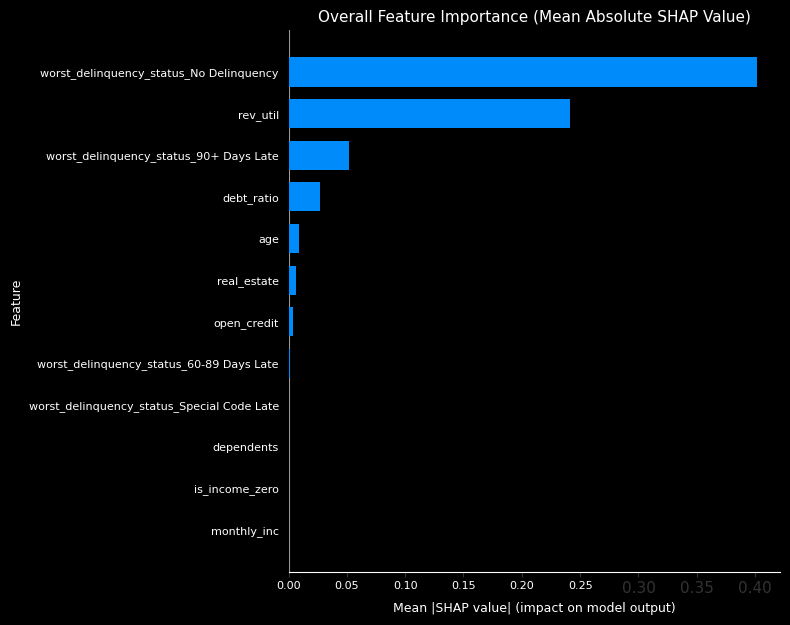

Generating SHAP Summary Beeswarm Plot...


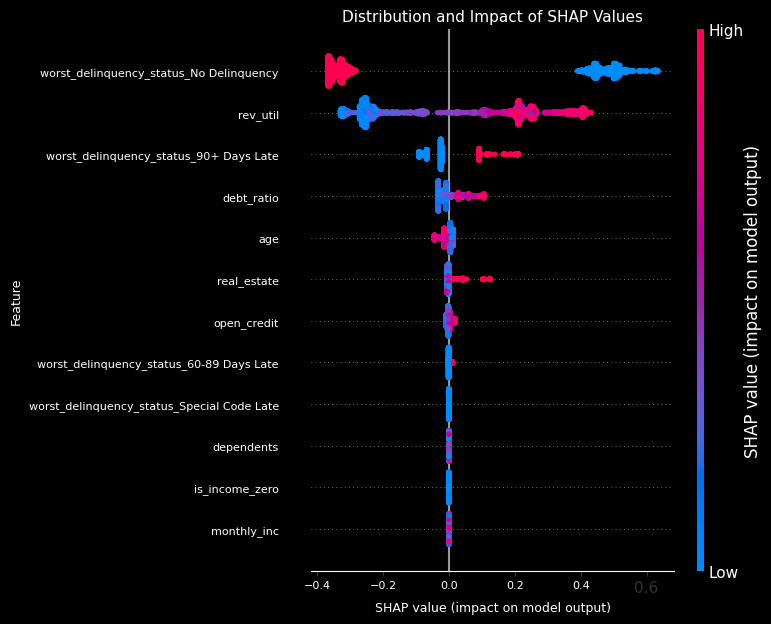

In [10]:
# Best model from Optuna
best_params = {
    'learning_rate': 0.006197243013584369,
    'max_depth': 3,
    'min_samples_split': 40,
    'min_samples_leaf': 49,
    'subsample': 0.7550247147506223,
}

# Train the final model
final_model = GradientBoostingClassifier(random_state=42, **best_params)
final_model.fit(X_temp, y_temp)

print("Final Gradient Boosting model trained.")

# Use SHAP to explain the model's predictions on the test set
print("Calculating SHAP values...")
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# SHAP Plots

# Overall feature importance
print("Generating SHAP Summary Bar Plot...")
plt.figure(figsize=(7, 4))
shap.summary_plot(
    shap_values, X_test, plot_type="bar", show=False,
    color_bar_label="Mean |SHAP value| (impact on model output)"
)
plt.title("Overall Feature Importance (Mean Absolute SHAP Value)", fontsize=11, color='white')
plt.xlabel("Mean |SHAP value| (impact on model output)", fontsize=9, color='white')
plt.ylabel("Feature", fontsize=9, color='white')
plt.xticks(color='white', fontsize=8)
plt.yticks(color='white', fontsize=8)
plt.tight_layout()
plt.gca().set_facecolor('black')
plt.show()

# Distribution and direction of impact
print("Generating SHAP Summary Beeswarm Plot...")
plt.figure(figsize=(7, 4))
shap.summary_plot(
    shap_values, X_test, show=False,
    color_bar_label="SHAP value (impact on model output)"
)
plt.title("Distribution and Impact of SHAP Values", fontsize=11, color='white')
plt.xlabel("SHAP value (impact on model output)", fontsize=9, color='white')
plt.ylabel("Feature", fontsize=9, color='white')
plt.xticks(color='white', fontsize=8)
plt.yticks(color='white', fontsize=8)
plt.tight_layout()
plt.gca().set_facecolor('black')
plt.show()

Generating SHAP Dependence Plot for 'rev_util'...


<Figure size 700x400 with 0 Axes>

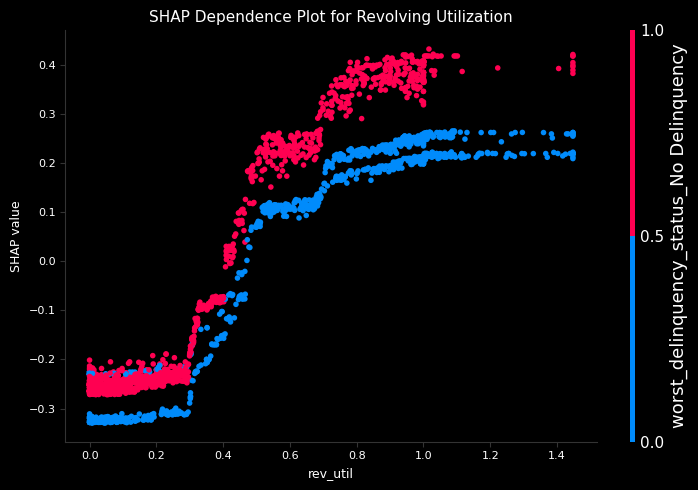

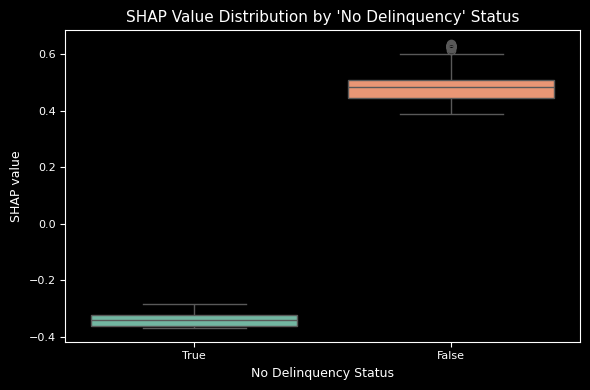

In [18]:
# Effect of 'rev_util'
print("Generating SHAP Dependence Plot for 'rev_util'...")
plt.figure(figsize=(7, 4))
shap.dependence_plot(
    "rev_util", shap_values, X_test, interaction_index="auto", show=False
)
plt.title("SHAP Dependence Plot for Revolving Utilization", fontsize=11, color='white')
plt.xlabel("rev_util", fontsize=9, color='white')
plt.ylabel("SHAP value", fontsize=9, color='white')
plt.xticks(color='white', fontsize=8)
plt.yticks(color='white', fontsize=8)
plt.tight_layout()
plt.gca().set_facecolor('black')
plt.show()

# Effect of 'worst_delinquency_status_No Delinquency'
shap_df = pd.DataFrame({
    'SHAP value': shap_values[:, X_test.columns.get_loc("worst_delinquency_status_No Delinquency")],
    'worst_delinquency_status_No Delinquency': X_test["worst_delinquency_status_No Delinquency"].astype(str)
})
plt.figure(figsize=(6, 4))
sns.boxplot(
    x='worst_delinquency_status_No Delinquency',
    y='SHAP value',
    hue='worst_delinquency_status_No Delinquency',
    data=shap_df,
    palette='Set2',
    legend=False
)
plt.title("SHAP Value Distribution by 'No Delinquency' Status", fontsize=11, color='white')
plt.xlabel("No Delinquency Status", fontsize=9, color='white')
plt.ylabel("SHAP value", fontsize=9, color='white')
plt.xticks(color='white', fontsize=8)
plt.yticks(color='white', fontsize=8)
plt.tight_layout()
plt.gca().set_facecolor('black')
plt.show()